In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, ShiftScaleRotate)


/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [40]:
# Paths to data files (images and meta data i.e. labels)
# PROJECT_PATH   = '.'
# META_DATA_PATH = f'{PROJECT_PATH}/data/train-metadata.csv'
# IMAGE_DIR      = f'{PROJECT_PATH}/data/train-image/image/'

# Paths to data files (images and meta data i.e. labels)
PROJECT_PATH   = '/kaggle/input/isic-2020-jpg-256x256-resized'
META_DATA_PATH = f'/kaggle/input/isic-2020-training-groundtruth/ISIC_2020_Training_GroundTruth.csv'
IMAGE_DIR      = f'{PROJECT_PATH}/train-image/image/'


# Image file extention
IMAGE_FILE_EXT = '.jpg' 

DATA_SUBSET    = 30000

embedding_dims = 2
BATCH_SIZE = 32
epochs = 30

LEARNING_RATE  = 0.001

In [47]:
# Load the metadata file
metadata = pd.read_csv(META_DATA_PATH)

# Add the file extension to isic_id to match image filenames
metadata['image_file'] = metadata['image_name'] + IMAGE_FILE_EXT

# Create a dictionary to map image filename to target class
image_to_label = dict(zip(metadata['image_file'], metadata['target']))

# Directory containing images
image_paths = [os.path.join(IMAGE_DIR, img) for img in os.listdir(IMAGE_DIR) if img in image_to_label]

# Check if all images were found in the metadata
print(f"Found {len(image_paths)} images out of {len(metadata)} labels in the metadata.")

Found 33126 images out of 33126 labels in the metadata.


In [48]:
# TESTING PURPOSES: use only a subset of the data
pos_paths = [img for img in image_paths if image_to_label[os.path.basename(img)] == 1][:DATA_SUBSET // 2] # Mela
neg_paths = [img for img in image_paths if image_to_label[os.path.basename(img)] == 0][:DATA_SUBSET // 2] # Normal

image_paths = pos_paths + neg_paths

print(f"Total = {len(image_paths)}, Pos = {len(pos_paths)}, Neg = {len(neg_paths)}")

Total = 15584, Pos = 584, Neg = 15000


In [49]:
# Resize and normalize the images
def preprocess_images(paths, img_size=(256, 256)):
    labels = []
    for path in paths:
            labels.append(image_to_label[os.path.basename(path)])
    return np.array(paths), np.array(labels)

# Preprocess the images and get labels
images, labels = preprocess_images(image_paths)

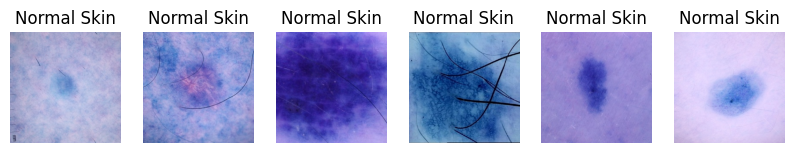

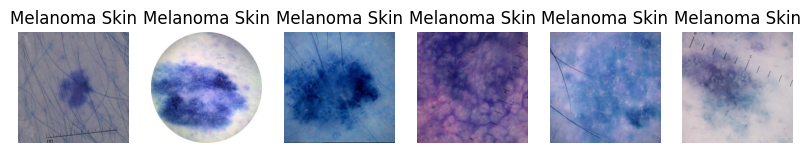

In [50]:
# Function to display images
def display_images(images, title, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.imread(images[i]) / 255.0)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Select 5 images from each class (normal and melanoma)
normal_images = images[labels == 0][:6]  # Assuming 0 is for normal skin
melanoma_images = images[labels == 1][:6]  # Assuming 1 is for melanoma

# Display images from both classes
display_images(normal_images, title="Normal Skin", num_images=6)
display_images(melanoma_images, title="Melanoma Skin", num_images=6)


In [51]:
images[labels==1][7:8]

array(['/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_8157654.jpg'],
      dtype='<U78')

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load an example image
def load_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
    return img

# Define the augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate image by 0-20 degrees
    width_shift_range=0.1,    # Shift horizontally by 0-20% of the width
    height_shift_range=0.1,   # Shift vertically by 0-20% of the height
    zoom_range=0.1,           # Zoom in/out by 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest'       # Fill in any missing pixels
)

# Example usage: Augment an image and plot the results
def augment_and_plot(image_path, augmentations=5):
    img = load_image(image_path)
    
    i = 0
    plt.figure(figsize=(10, 10))
    for batch in datagen.flow(img, batch_size=1):
        plt.subplot(1, augmentations, i + 1)
        plt.imshow(batch[0].astype('uint8'))
        plt.axis('off')
        i += 1
        if i == augmentations:  # Stop after the specified number of augmentations
            break
    plt.show()



In [12]:
print(images[labels==1][7:8][0])

/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_8157654.jpg


# DATA Augmentation

In [54]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Create a folder to save the augmented images
def create_save_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define the augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotate images by 0-20 degrees
    width_shift_range=0.2,    # Shift horizontally by 0-20% of the width
    height_shift_range=0.2,   # Shift vertically by 0-20% of the height
    zoom_range=0.2,           # Zoom in/out by 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest'       # Fill in missing pixels
)

# Function to augment images from file paths and save them
def augment_and_save(X_train_paths, save_dir, augmentations_per_image=5):
    create_save_dir(save_dir)
    image_count = 0  # To keep track of the total number of images
    
    for i, img_path in enumerate(X_train_paths):
        # Load the image from the file path
        img = load_img(img_path, target_size=(256, 256))  # Adjust target size as needed
        img = img_to_array(img)  # Convert to NumPy array
        img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
        
        # Augment and save the images
        augment_iter = datagen.flow(img, batch_size=1)
        for j in range(augmentations_per_image):
            batch = next(augment_iter)  # Get the next augmented image
            augmented_image = array_to_img(batch[0])  # Convert to PIL image format
            save_path = os.path.join(save_dir, f'augmented_image_{i}_{j}.png')
            augmented_image.save(save_path)  # Save the augmented image
            image_count += 1
    
    print(f"Saved {image_count} augmented images to {save_dir}")




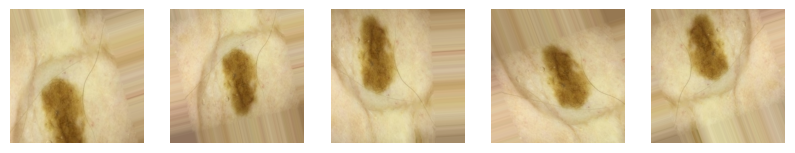

In [60]:

# Path to the medical image
image_path = images[labels==1][99:100][0]

# Augment and plot 5 versions of the image
augment_and_plot(image_path, augmentations=5)

In [53]:
images[0]

'/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_9228573.jpg'

# Saving the augmented images in folder

In [55]:
save_directory = 'Augmented_Images'  # Directory to save augmented images

# Save 5 augmented versions per image
augment_and_save(images, save_directory, augmentations_per_image=5)

Saved 77920 augmented images to Augmented_Images


CSV file

In [56]:
df=pd.read_csv(/kaggle/input/isic-2020-training-groundtruth/ISIC_2020_Training_GroundTruth.csv)
df.head()

SyntaxError: invalid syntax (2154236505.py, line 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each class (0: normal, 1: melanoma)
unique, counts = np.unique(labels, return_counts=True)

# Calculate percentages
total = np.sum(counts)
percentages = counts / total * 100

# Plot the bar graph
plt.figure(figsize=(6, 4))
bars = plt.bar(unique, counts, color=['blue', 'red'])
plt.xticks([0, 1], ['Normal Skin', 'Melanoma Skin'])
plt.ylabel('Count')
plt.title('Distribution of Normal and Melanoma Images in the Dataset')

# Add count and percent on top of the bars
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}\n({percent:.1f}%)', 
             ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()


In [ ]:
# Split the data into training and test sets
# Use stratified sampling to ensure classes are split evenly between the sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)
print(len(train_labels))

In [ ]:
import numpy as np
from collections import Counter

# Assuming train_images and train_labels are NumPy arrays or PyTorch tensors
print("Original class distribution:", Counter(train_labels))

# Split the images into class 0 and class 1
class_0_images = train_images[train_labels == 0]
class_1_images = train_images[train_labels == 1]
class_0_labels = train_labels[train_labels == 0]
class_1_labels = train_labels[train_labels == 1]

# Number of samples to match class 0
num_class_0 = len(class_0_images)
num_class_1 = len(class_1_images)

# If class 1 has fewer samples, oversample it
if num_class_1 < num_class_0:
    # Randomly choose from class_1_images to oversample it
    oversample_indices = np.random.choice(np.arange(num_class_1), size=num_class_0 - num_class_1, replace=True)
    oversampled_class_1_images = class_1_images[oversample_indices]
    oversampled_class_1_labels = class_1_labels[oversample_indices]
    
    # Combine original class 1 images with the oversampled ones
    class_1_images = np.concatenate([class_1_images, oversampled_class_1_images], axis=0)
    class_1_labels = np.concatenate([class_1_labels, oversampled_class_1_labels], axis=0)

# Concatenate class 0 and the new class 1 images to get the final balanced dataset
train_images = np.concatenate([class_0_images, class_1_images], axis=0)
train_labels = np.concatenate([class_0_labels, class_1_labels], axis=0)


print("Resampled class distribution:", Counter(train_labels))
